In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict
from itertools import chain
from collections import Counter
import torch
import utils

In [10]:
DATA_FOLDER = os.path.join('data', 'Forehead')
TRAIN_IMAGES_FOLDER = os.path.join(DATA_FOLDER, 'train', 'images')
TRAIN_LABELS_FOLDER = os.path.join(DATA_FOLDER, 'train', 'labels')
TRAIN_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'train', 'masks')
TRAIN_BIN_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'train', 'bin_masks')

VAL_IMAGES_FOLDER = os.path.join(DATA_FOLDER, 'val', 'images')
VAL_LABELS_FOLDER = os.path.join(DATA_FOLDER, 'val', 'labels')
VAL_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'val', 'masks')
VAL_BIN_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'val', 'bin_masks')


TEST_IMAGES_FOLDER = os.path.join(DATA_FOLDER, 'test', 'images')
TEST_LABELS_FOLDER = os.path.join(DATA_FOLDER, 'test', 'labels')
TEST_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'test', 'masks')
TEST_BIN_MASKS_FOLDER = os.path.join(DATA_FOLDER, 'test', 'bin_masks')

key_to_image_folder = {
    'train': {'images': TRAIN_IMAGES_FOLDER, 'labels': TRAIN_LABELS_FOLDER},
    'val': {'images': VAL_IMAGES_FOLDER, 'labels': VAL_LABELS_FOLDER},
    'test': {'images': TEST_IMAGES_FOLDER, 'labels': TEST_LABELS_FOLDER}, 
}

In [6]:
train_images_files = utils.only_jpg_files(os.listdir(TRAIN_IMAGES_FOLDER))
test_images_files = utils.only_jpg_files(os.listdir(TEST_IMAGES_FOLDER))
val_images_files = utils.only_jpg_files(os.listdir(VAL_IMAGES_FOLDER))
print(f'Train images - {len(train_images_files)}')
print(f'Validation images - {len(val_images_files)}')
print(f'Test images - {len(test_images_files)}')

Train images - 18200
Validation images - 530
Test images - 840


In [7]:
def get_image_dimensions(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Get the dimensions of the image
    height, width = image.shape[:2]
    
    return height, width

In [8]:
train_full_images_path = [os.path.join(TRAIN_IMAGES_FOLDER, img) for img in train_images_files]
val_full_images_path = [os.path.join(VAL_IMAGES_FOLDER, img) for img in val_images_files]
test_full_images_path = [os.path.join(TEST_IMAGES_FOLDER, img) for img in test_images_files]
shapes = [
    get_image_dimensions(filepath) for filepath in chain(train_full_images_path,
                                                         val_full_images_path,
                                                         test_full_images_path)
]
print(Counter(shapes).keys())
print(Counter(shapes).values())

dict_keys([(480, 640)])
dict_values([19570])


In [4]:
train_rand_images = random.choices(train_images_files, k=3)
test_rand_images = random.choices(test_images_files, k=3)
val_rand_images = random.choices(val_images_files, k=3)
print(train_rand_images, test_rand_images, val_rand_images)

['1974.2.jpg', '156.4.jpg', '2014.1.jpg'] ['2444.0.jpg', '2463.1.jpg', '2417.9.jpg'] ['2519.3.jpg', '2528.6.jpg', '2502.3.jpg']


In [5]:
def create_random_dict(image_type: str, images: List[str]) -> Dict:
    random_images_dict = dict()
    for image_filename in images:
        file_no_ext = Path(image_filename).stem
        label_folder = key_to_image_folder[image_type]['labels']
        bbox = utils.get_bbox(file_no_ext, label_folder)
        image_folder = key_to_image_folder[image_type]['images']
        full_image_filename = os.path.join(image_folder, image_filename)
        random_images_dict[full_image_filename] = {'type': image_type, 'bbox': bbox}
    return random_images_dict

In [6]:
all_random_data = dict()
train_random_data = create_random_dict('train', train_rand_images)
val_random_data = create_random_dict('val', val_rand_images)
test_random_data = create_random_dict('test', test_rand_images)
# print(f'Train - {train_random_data} \nTest - {val_random_data}\nVal - {test_random_data}')
all_random_data.update(train_random_data)
all_random_data.update(val_random_data)
all_random_data.update(test_random_data)
print(all_random_data)

{'data/Forehead/train/images/1974.2.jpg': {'type': 'train', 'bbox': [0.2452445652173914, 0.21750452898550726, 0.5764266304347826, 0.3397871376811594]}, 'data/Forehead/train/images/156.4.jpg': {'type': 'train', 'bbox': [0.35532407407407407, 0.7342372134038802, 0.7256944444444444, 0.8334435626102292]}, 'data/Forehead/train/images/2014.1.jpg': {'type': 'train', 'bbox': [0.34629755434782616, 0.7292798913043478, 0.678328804347826, 0.8538269927536232]}, 'data/Forehead/val/images/2519.3.jpg': {'type': 'val', 'bbox': [0.505944293478261, 0.6737998188405797, 0.8311820652173912, 0.8164628623188406]}, 'data/Forehead/val/images/2528.6.jpg': {'type': 'val', 'bbox': [0.23760190217391308, 0.6987092391304348, 0.5042459239130435, 0.8221240942028986]}, 'data/Forehead/val/images/2502.3.jpg': {'type': 'val', 'bbox': [0.43716032608695654, 0.7723052536231884, 0.6766304347826088, 0.862884963768116]}, 'data/Forehead/test/images/2444.0.jpg': {'type': 'test', 'bbox': [0.2834578804347826, 0.6998414855072463, 0.65

In [7]:
# Function to draw bounding box on an image
def draw_bounding_box(image, bbox, color=(255, 0, 0), thickness=2):
    h, w, _ = image.shape
    x_min = int(bbox[0] * w)
    y_min = int(bbox[1] * h)
    x_max = int(bbox[2] * w)
    y_max = int(bbox[3] * h)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    return image

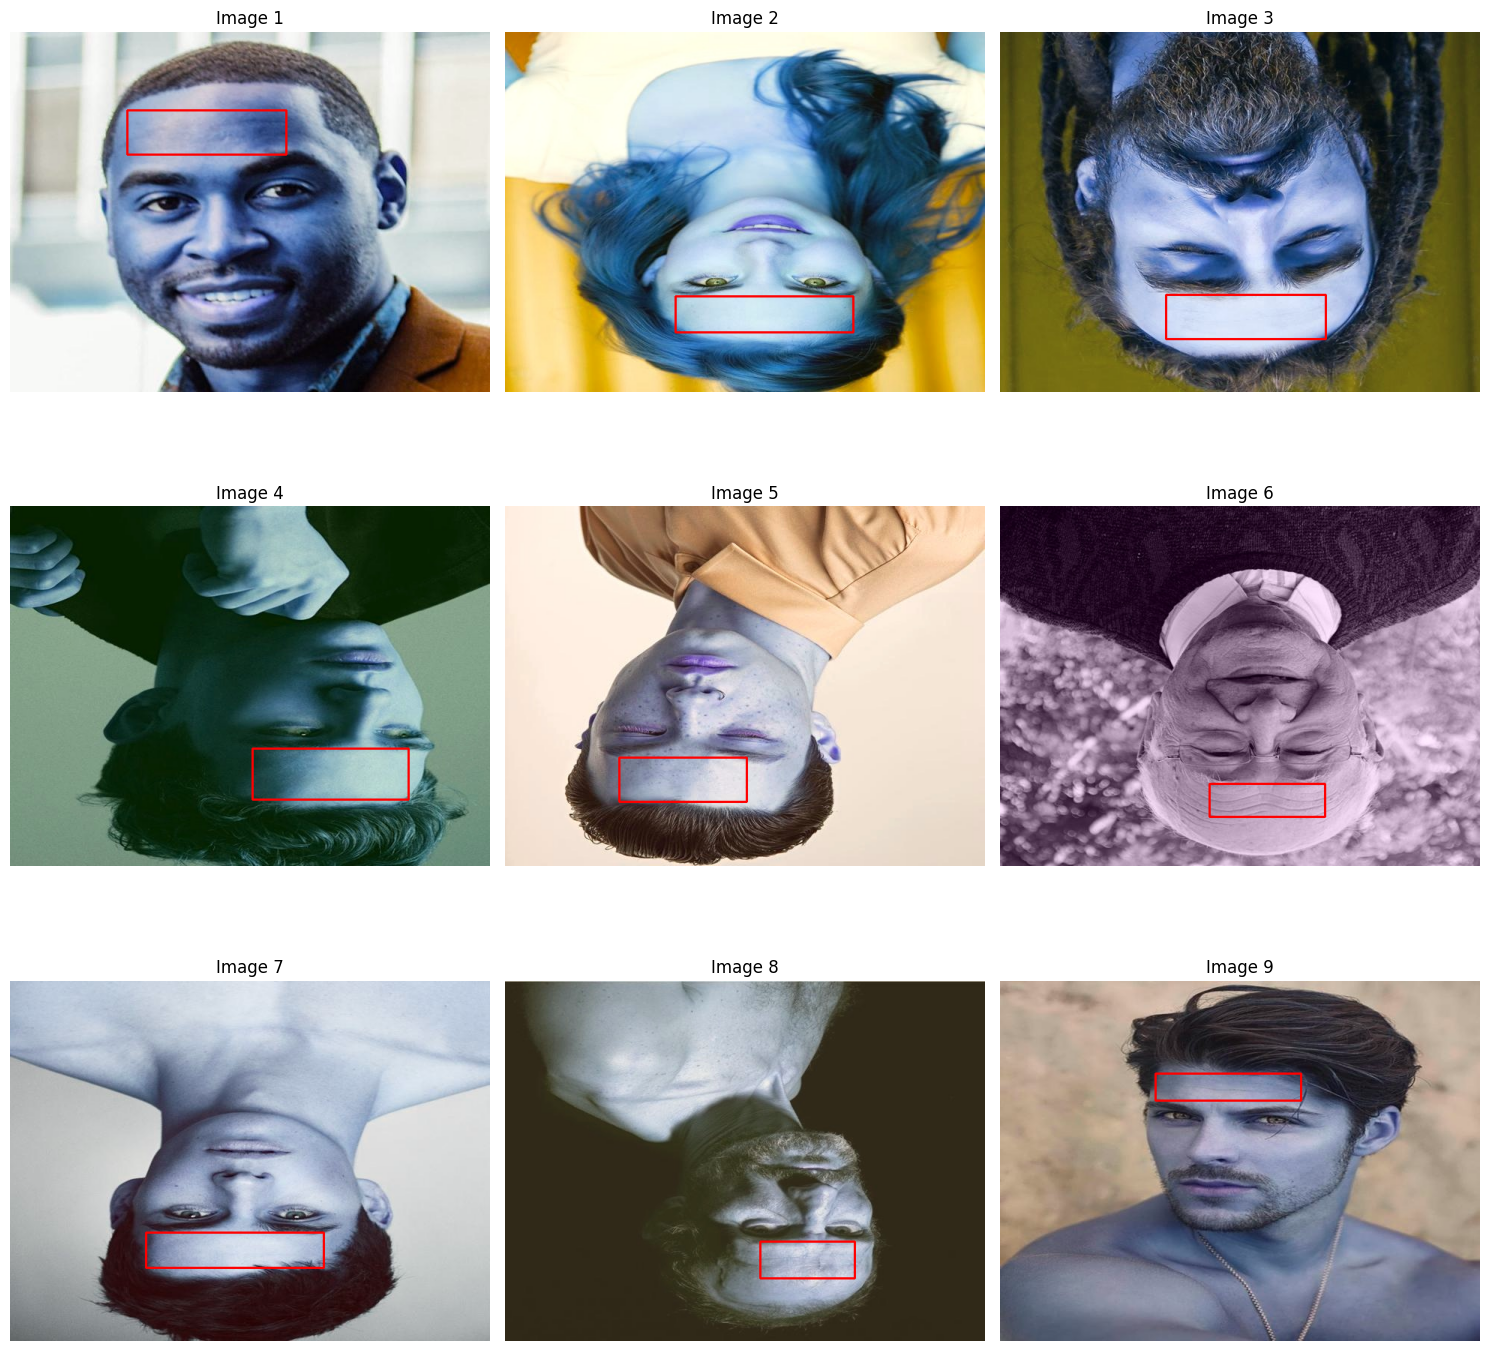

In [8]:
plt.figure(figsize=(15, 15))
for i, (image_path, data) in enumerate(all_random_data.items()):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    image_with_bbox = draw_bounding_box(image, data['bbox'])
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_with_bbox)
    plt.title(f'Image {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
from forehead_search import config
from forehead_search.model import DivideBy255
from torchvision import transforms
from imutils import paths


test_transforms = transforms.Compose([transforms.ToPILImage(),
        transforms.Resize((config.INPUT_IMAGE_HEIGHT,
            config.INPUT_IMAGE_WIDTH)),
        transforms.ToTensor(), DivideBy255()])


celeb_images = sorted(list(paths.list_images('data/celebrity')))
unet = torch.load('output/focal_unet.pth').to(config.DEVICE)
unet.eval()


UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [18]:
def masked_image(image, mask):
    return image * mask

In [17]:
celeb_dict = {}
for i, img in enumerate(celeb_images):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mX = test_transforms(image)
    mX = torch.unsqueeze(mX, 0)
    mX = mX.to(config.DEVICE)
    with torch.no_grad():
        mask = unet(mX)
    mask = torch.squeeze(mask, 0)
    mask = torch.sigmoid(mask)
    mask = (mask > 0.5).float()
    masked_image = mX * mask
    masked_image = torch.squeeze(masked_image, 0)
    celeb_dict[img] = masked_image


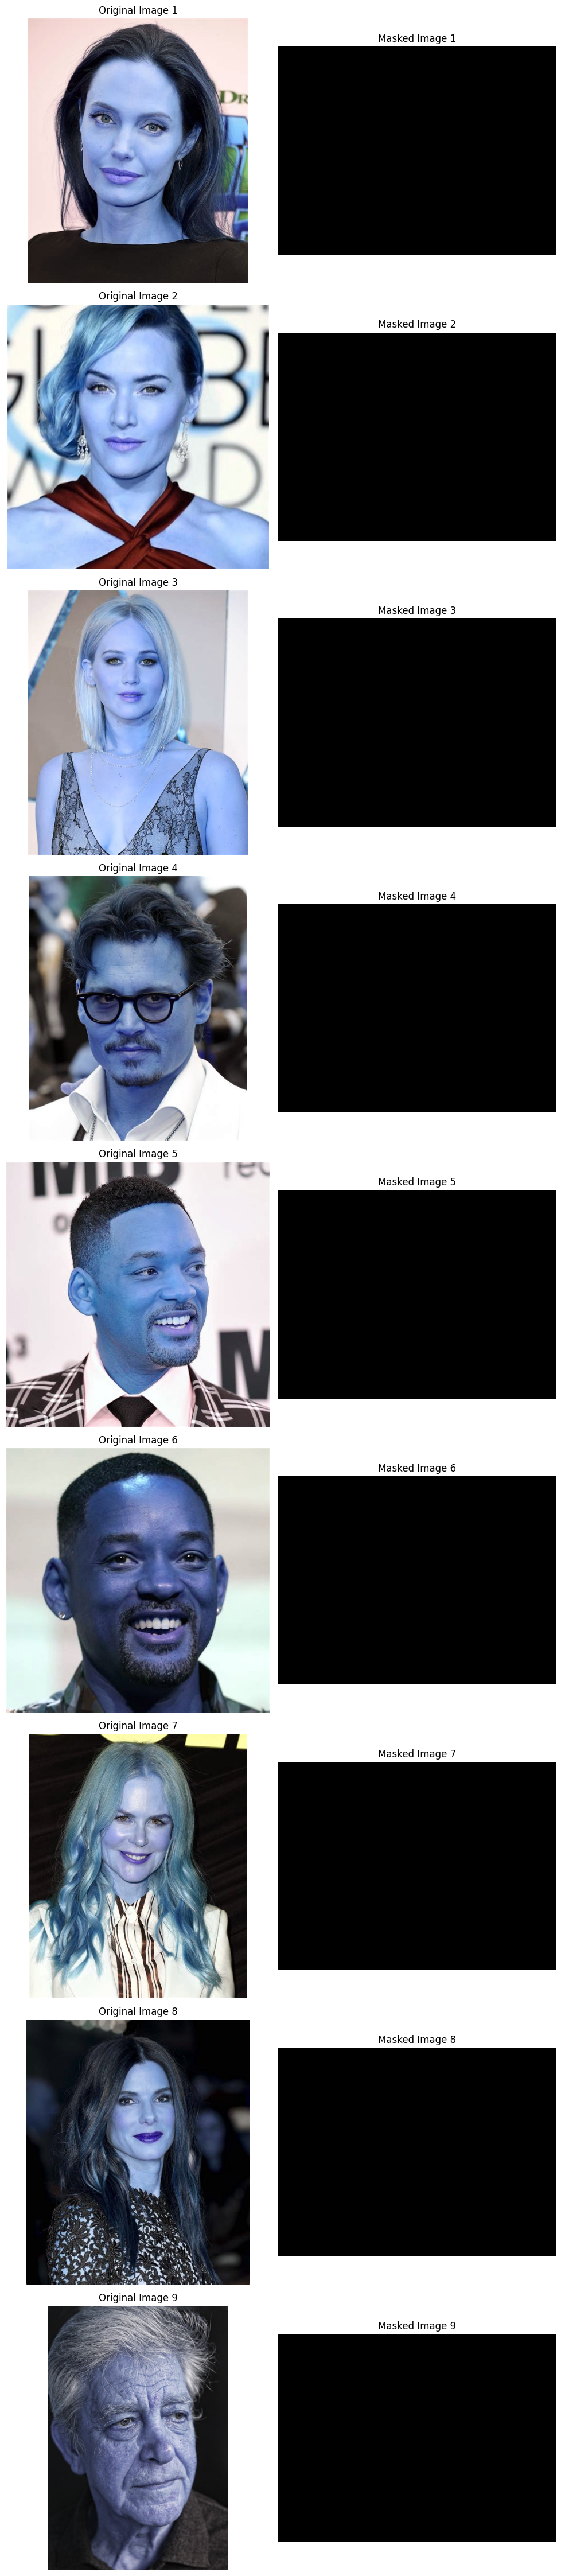

In [19]:
# Number of images
num_images = len(celeb_images)

# Create a figure with appropriate size
plt.figure(figsize=(10, num_images * 5))

for i, (img, m_image) in enumerate(celeb_dict.items()):
    original_img = cv2.imread(img)
    masked_img = m_image.permute(1,2,0)
    masked_img = masked_img.to('cpu')
    masked_img = masked_img.numpy()
    # Plot original image
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f'Original Image {i+1}')
    
    # Plot masked image
    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(masked_img)
    plt.axis('off')
    plt.title(f'Masked Image {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
def create_bounding_box_mask(image_path, bounding_box, output_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    height, width = image.shape[:2]
    
    mask = np.zeros((height, width), dtype=np.float16)
    
    x_min, y_min, x_max, y_max = bounding_box
    
    x_min = int(x_min * width)
    y_min = int(y_min * height)
    x_max = int(x_max * width)
    y_max = int(y_max * height)
    
    mask[y_min:y_max, x_min:x_max] = 255
    np.save(output_path, mask)
    
    return mask

In [17]:
for img in train_full_images_path:
    file_no_ext = Path(img).stem
    output_path = os.path.join(TRAIN_BIN_MASKS_FOLDER, file_no_ext)
    bbox = utils.get_bbox(file_no_ext, TRAIN_LABELS_FOLDER)
    create_bounding_box_mask(img, bbox, output_path)

In [27]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop


image = Image.open(train_full_images_path[0])
transform = transforms.Compose([
    transforms.PILToTensor()
])

# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(image)
(_, H, W) = img_tensor.shape
encFeatures = CenterCrop([100, 250])(img_tensor)
transform = transforms.Compose([
    transforms.ToPILImage()
])
crop_img = transform(encFeatures)
crop_img.show()
print(crop_img.size)

(250, 100)


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [33]:
import torch
from torch.nn import BCELoss, Sigmoid, BCEWithLogitsLoss
m = Sigmoid()
loss = BCELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
output = loss(m(input), target)
output.backward()
print(output)

tensor(0.8334, grad_fn=<BinaryCrossEntropyBackward0>)


In [31]:
loss = BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output.backward()

In [34]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(output, target)  # -log(sigmoid(1.5))

tensor(0.2014)

In [24]:
tensor1 = torch.randint(0, 2, (3,3,3))
tensor2 = torch.randint(0, 2, (3,3,3))
display(tensor1)
display(tensor2)
display(tensor1*tensor2)



tensor([[[1, 0, 0],
         [0, 0, 1],
         [1, 0, 1]],

        [[0, 0, 0],
         [1, 1, 0],
         [1, 1, 1]],

        [[1, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])

tensor([[[1, 0, 0],
         [1, 1, 0],
         [0, 0, 1]],

        [[0, 0, 0],
         [1, 1, 0],
         [0, 0, 1]],

        [[0, 1, 0],
         [1, 0, 1],
         [1, 0, 0]]])

tensor([[[1, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],

        [[0, 0, 0],
         [1, 1, 0],
         [0, 0, 1]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])